# Examine the features and their contribution to the prediction

In [1]:
# Import needed packages
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import os
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from scipy.stats.mstats import winsorize

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

#Set a random state
rs = 4

#Set amount of splits
cv_split = 5

In [2]:
#Define monetary_score
def monetary_score_func(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    monetary_value = (cm[0,0] * 0) + (cm[1, 0] * -5) + (cm[0, 1] * -25) + (cm[1, 1] * 5)
    max_monetary_value = (cm[1,0] + cm[1,1]) * 5
    return (monetary_value / max_monetary_value)

monetary_score = make_scorer(monetary_score_func)

In [3]:
# get current directory 
path = os.getcwd() 

# get parent directory 
parent = os.path.dirname(path)

# move to the directory with data
train_csv = os.path.join(parent, "data", "train.csv")

#Import our dataset
dataset = pd.read_csv(train_csv, delimiter = '|')

dataset_org = dataset.copy()
dataset = dataset[dataset['scannedLineItemsPerSecond'] < 4]
cutted = len(dataset_org)-len(dataset)
print(f"{cutted} ({cutted/len(dataset_org)}) entries removed .")


dataset['scannedLineItemsPerSecond'] = np.log(dataset['scannedLineItemsPerSecond']+1)
dataset['valuePerSecond'] = np.log(dataset['valuePerSecond']+1)
dataset['lineItemVoidsPerPosition'] = winsorize(dataset['lineItemVoidsPerPosition'], limits=[0., .1])

4 (0.0021287919105907396) entries removed .


<AxesSubplot:>

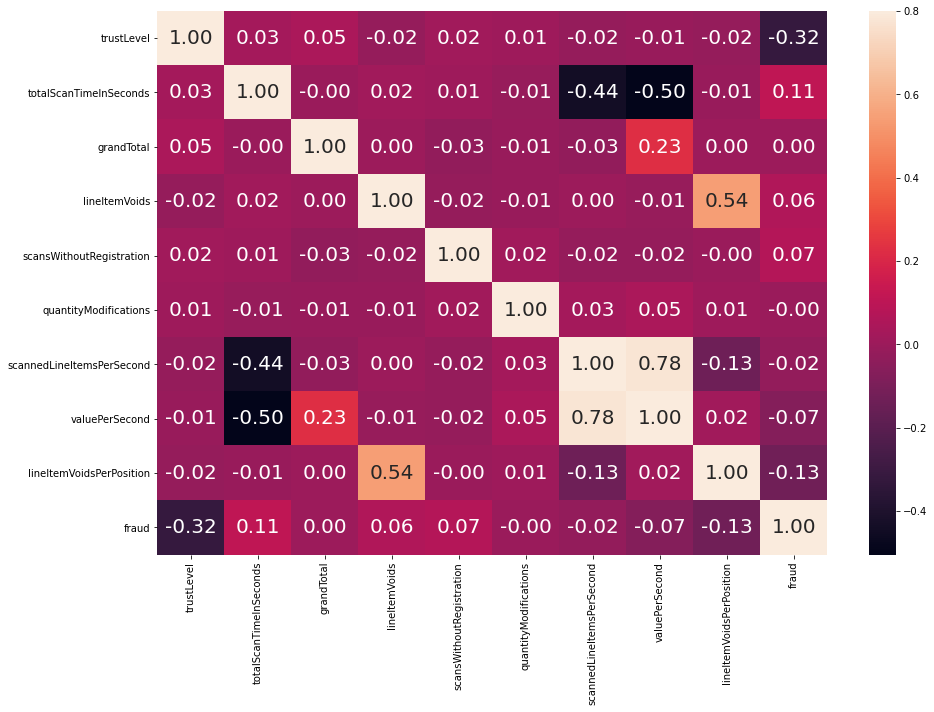

In [4]:
# see the correlation of the features
fig = plt.figure(figsize=(15,10))
sns.heatmap(dataset.corr(), annot=True, annot_kws={"size": 20}, vmax=0.8, fmt=".2f")

#### Features with low correlation to fraud
- grandTotal
- lineItemVoids
- scansWithoutRegistration
- quantityModifications
- scannedLineItemsPerSecond
- valuePerSecond

#### Features with "high" correlation to fraud
- trustLevel

In [5]:
#Split X and y
X = dataset.drop('fraud', axis=1)
y = dataset.fraud

In [6]:
# take a closer look on the data and its features
X

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,5,1054,54.70,7,0,3,0.027143,0.050596,0.241379
1,3,108,27.36,5,2,4,0.121890,0.225807,0.357143
2,3,1516,62.16,3,10,5,0.008539,0.040184,0.230769
3,6,1791,92.31,8,4,4,0.016062,0.050257,0.275862
4,5,430,81.53,3,7,2,0.060898,0.173621,0.111111
...,...,...,...,...,...,...,...,...,...
1874,1,321,76.03,8,7,2,0.069201,0.212571,0.347826
1875,1,397,41.89,5,5,0,0.063436,0.100313,0.192308
1876,4,316,41.83,5,8,1,0.090697,0.124316,0.166667
1877,2,685,62.68,1,6,2,0.034437,0.087556,0.041667


In [7]:
# see how the model performs 

cv = StratifiedKFold(n_splits=cv_split, shuffle=True, random_state=rs)
   
model = SVC(kernel="linear", random_state=rs)

# create the model pipeline

pipe_model = Pipeline([    
        ("model", model)
    ])

cv_results = cross_validate(pipe_model, X, y, cv=cv_split, scoring=monetary_score, n_jobs=-1)
print("Model performance on folds:\t\t",cv_results['test_score'])
print("Model mean monetary score:\t\t", cv_results['test_score'].mean())
print("Model double standard deviation:\t", 2*cv_results['test_score'].std())

Model performance on folds:		 [-0.3        -0.71428571 -0.33333333 -0.47619048 -0.28571429]
Model mean monetary score:		 -0.42190476190476184
Model double standard deviation:	 0.3221019401741405


# Check feature importance and take a look "into" the model with SHAP

In [8]:
# for fitting the model to the data to apply SHAP we need the good old train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rs, test_size=0.2, stratify=y)
model.fit(X_train, y_train)

#Achieved score on test data
model.score(X_test, y_test)

0.9733333333333334

### SHAP Value

In [9]:
import shap
shap.initjs()

In [10]:
# because it would take too much time to compute the shap values for all datapoints we only take some
X_train = shap.kmeans(X_train, 50)

In [11]:
explainer = shap.KernelExplainer(pipe_model.predict, X_train)
shap_values = explainer.shap_values(X_test)

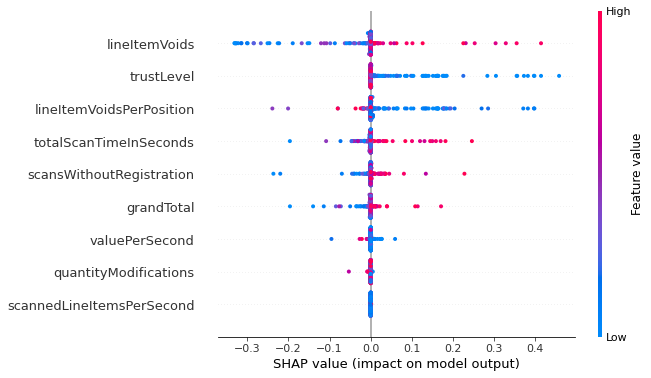

In [12]:
shap.summary_plot(shap_values, X_test, plot_size=0.5)

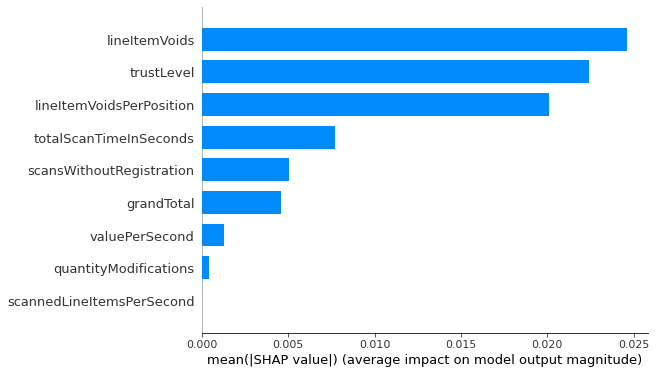

In [13]:
shap.summary_plot(shap_values, X_test, plot_size=0.5, plot_type='bar')